In [22]:
#fmain
import numpy as np
import os
import pandas as pd
import pprint

from matplotlib import cm
import pycircos

import fconfig as cfg
# pip show pycircos - location of package
# /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pycircos/pycircos.py
DBG = False
DBG1 = False
DBG_ARC = False

COLOR_DICT = cfg.unh_colors1
# COLOR_DICT = {}
# # for key in cfg.color_names.keys():
# #     COLOR_DICT[key] = cfg.color_names[key][0]

In [23]:
class ColorDict:
    def __init__(self):
        # Create dict with key = network #
        self.color_dict = {}

    def get_matplot_colors(self,colormap_name,num):
        color_map = cm.get_cmap(colormap_name, num)
        for i in range(color_map.N):
            rgba = color_map(i)
            self.color_dict[i] = cm.colors.rgb2hex(rgba)
        return self.color_dict

    def print_map(self,name,num):
        return cm.get_cmap(name,num)

# TEST
# ColorDict().get_matplot_colors('rainbow',4)   
# ColorDict().print_map('rainbow',15)  
# ColorDict().print_map('viridis',15)    

In [24]:
def print_slice(label,d,num):
    print(label," First", num, dict(list(d.items())[:num]))

class NodeData:
    def __init__( self, parts:list, nodes:list, sheet_matrix:str,
                  nets:list ):
        ''' generates data structure used to draw arcs/lines
            REQUIRES:
            src = (part, abs_col)
            dest = (part, abs_col)
            color = network
        '''
        # read in matrix sheet 
        self.dest_node_dict = self.read_matrix_sheet(sheet_matrix )
  
        # create dict of nodes node:part,abs_col
        self.src_node_dict = self.create_part_node_map(parts,nodes)

        # create mapping of node to network (used for colors)
        self.node_net_map = self.create_node_net_map(nodes,nets)

        # generate list of src and dest nodes
        self.nodes_list = self.create_nodes_list(self.node_net_map)
        
        self.parts_net_dict = self.parts_net_dict(parts,nodes)
        if DBG:
            print_slice( "\nMatrix Nodes:", dict(list(self.dest_node_dict.items())[:5]))
            print_slice("Src Nodes:",self.src_node_dict,10)
            print("Nodes Arcs:\n",self.nodes_list[:5])


    def read_matrix_sheet(self,sheet_matrix):
        # returns list of columns numbers of first non-zero node
        
        self.matrix_df = pd.DataFrame(pd.read_excel(cfg.Ginput_file,
                sheet_name=sheet_matrix,))
        print("\n&&& WARNING!!! THIS IS INCORRECT _ RETURNS 0(which is a valid node)") 
        #            for rows with all zeros - I can fix if I insert another column?
        nonzero = np.argmax(self.matrix_df.values!=0,axis=0) #axis=0 is colum
       
        nonzero = nonzero[1:] # header is a 0
        # # cols are zero-based so add 1 to each 
        # nodes = [ a+1 for a in nonzero]
        # print(nodes)
        n = 1 # list is zero based
        d = {}
        for col in nonzero:
            d[n] = {
                'col':col+1,
                'dest_node':col+1,
                }
            n+=1
        return d

    def create_part_node_map(self,parts,nodes):
        ''' returns a dict of key=node
        and items = (partition, partition_start_col)
        ''' 
        d = {}
        for col,(node,part) in enumerate(zip(nodes,parts)):
            # print(col+1,node,part)
            # d[node] = [part,col+1]
            d[node] = {
                'src_node':node,
                'part':part,
                'src_col':col+1,
            }
        # pprint.pp(node_dict)
        return d

    def create_node_net_map(self, nodes,nets):
        ''' give node get network'''
        d = {}
        for node,net in zip(nodes,nets):
            # print(col+1,node,part)
            # d[node] = [part,col+1]
            d[node] = {
                'node':node,
                'net':net,
            }
        return d   

    def create_nodes_list(self,node_net_dict:dict):
        ''' returns part, src_node 
        part src_node_col   dest_node_col  node_num
        '''
        rows = []
        s = self.src_node_dict
        d = self.dest_node_dict

        for node in s.keys():
            part = s[node]['part']
            src_node_col = s[node]['src_col']
            src_end = src_node_col +cfg.CHORD_WIDTH

            dest_node = d[node]['dest_node']
            dest_node_col = s[dest_node]['src_col']
            dest_end = dest_node_col +cfg.CHORD_WIDTH

            rows.append( (part,
                        src_node_col, src_end,
                        dest_node_col, dest_end,
                        node,
                        node_net_dict[node]['net']
                        ))
            if DBG:
                print(f'Partition {part} Node {node}->{dest_node}  ({node},{src_node_col}) ({dest_node},{dest_node_col})')
        return rows

    def parts_net_dict(self, parts, nodes):
        ''' 
        ''' 
        d = {}
    
        for col,(node,part) in enumerate(zip(nodes,parts)):
            # print('col',col,' NODE:',node, ' PART',part)
            d[node] = {
                'part':part,
                'node':node,
                'node_abs_col':col+1,
            }
        # pprint.pp(node_dict)
        return d


In [25]:
class DataList:
    def __init__(self, dfs, sheet, sheet_matrix ):
        self.sheet = sheet 
        self.parts_skip = []

        # Get the dataframe for this sheet
        #   sort by Partition (row=2) and then Network (row=0)
        #   ex: Blast - Sort by '751 blast' 
        #   must drop Column 0 bc it contains strings and sort can only sort same type
        df = dfs[self.sheet]
        df = df.drop(columns=[0])
        self.sheet_df = df.sort_values(by=[2,0], axis=1)

        # create sorted file for debugging
        self.create_sorted_csv()

        # 0,1,2 are rows to read in as a list, then remove index at col=0 
        self.netw_list = list(self.sheet_df.to_records()[0])[1:] 
        self.nodes_list = list(self.sheet_df.to_records()[1])[1:] 
        self.part_list = list(self.sheet_df.to_records()[2])[1:] 
        self.cols_list = list(range(1,len(self.netw_list)+1))

        # map data 
        self.matrix_node_map = self.NEWread_matrix_sheet( sheet_matrix ) #BRITT
        self.part_map = self.create_partition_map()

        self.add_nodes_to_part_map( )

        # this will be obselete soon! 
        # self.node_obj = NodeData( self.part_list, self.nodes_list,
        #                           sheet_matrix, self.netw_list )
        self.map_of_nodes = self.create_map_of_nodes()
        self.arc_list = self.create_node_rows()

        # print("\n\n\n ARCS FOR PART 6====================")
        # pprint.pp( self.part_map[6])

    def create_map_of_nodes(self):
        # nodes: rel_col, abs_col, part, network
        d = {}
        for p in self.part_map:
            node_dict = self.part_map[p]['nodes_start_stop']
            for node in node_dict.keys():
                if node not in d.keys():
                    d[node] = node_dict[node]
        return d
    
    def get_nodes_list(self): #OBSELETE SOON
        return self.node_obj.nodes_list

    def create_sorted_csv(self):
        #  DEBUG, create sorted CSV
        filename = self.sheet+'_sorted.csv'
        self.sheet_df.to_csv( filename )
        print(f'\n{"Overwrite" if os.path.exists(filename) else "Created"}: {filename}')


    def create_partition_map(self):
        ''' This CONTAINS most all data necessary to draw diagrams'''
        if DBG:
            print('Uniq Partitions:',list(set(self.part_list)))

        part_list = self.part_list
        netw_list = self.netw_list
      
        pdict = self.build_start_stop( part_list,netw_list)

        # get network abs cols and put part in there for printint
        for p in pdict.keys():
            pdict[p]['partid']=str(p)
            pdict[p]['rel_nets'] = self.build_start_stop(pdict[p]['nets'],None )
            # pprint.pp( pdict )
            if pdict[p]['len']==1:
                self.parts_skip.append(p)

        #GENERATE REL/ABS
        self.one_node_list = []
        for p in pdict.keys():
            rn = pdict[p]['rel_nets'] 
            pdict[p]['net_row'] = []
            for n in rn:
                # SUBTRACT 1 from LEN !!! NECESARY TO STAY WITHIN PARTITIONSx
                new_len = rn[n]['len']-1
                pdict[p]['net_row'].append( (p, rn[n]['start'], #rn[n]['end'],
                                                new_len, n ))
                if new_len <=1:
                    self.one_node_list.append(n)
            # pprint.pp( pdict )
            # return

        if DBG:
            print("create_partition_map")
            pprint.pp(pdict )
        if self.parts_skip:
            print(f'{self.sheet} Partitions with 1 Network: {self.parts_skip}')
        if self.one_node_list:
            print(f'{self.sheet} Networks with 1 Node: {self.one_node_list}')

        # add list of nodes to this partition 
  
        pdict_nodes = self.build_start_stop( part_list,self.nodes_list)
        # add nodes and list of rel_nodes to pdict - reuse build start stop
        for p in pdict.keys():
            pdict[p]['nodes']=pdict_nodes[p]['nets'] # reuse this key
            node_start_stop = self.build_start_stop(pdict_nodes[p]['nets'])
            # print(node_start_stop)
            pdict[p]['nodes_start_stop'] = node_start_stop

        # add Network for each Node into node_start_stop
        for p in pdict.keys():
            nets = pdict[p]['nets']
            nodes = pdict[p]['nodes']
            pdict[p]['nodes_start_stop']
            for ct,node in enumerate(nodes):
                pdict[p]['nodes_start_stop'][node]['netw'] = nets[ct]

                # add absolute col (used for debug info)
                part_col_start = pdict[p]['start']
                node_rel_start = pdict[p]['nodes_start_stop'][node]['start']
                # print("BRITT calc node abs cols and rel col",part_col_start,node_rel_start )
                pdict[p]['nodes_start_stop'][node]['node_abs_col'] = part_col_start+node_rel_start+1
                pdict[p]['nodes_start_stop'][node]['part'] = p

                # add skip key - don't draw - fill reason in later
                pdict[p]['nodes_start_stop'][node]['skip'] =[]
        
        # add nodes into rel_nets - get nodes for networks
        for p in pdict.keys():
            node_ss = pdict[p]['nodes_start_stop']
            for node in node_ss.keys():
                netw = node_ss[node]['netw']
                if 'nodes' not in pdict[p]['rel_nets'][netw].keys():
                    pdict[p]['rel_nets'][netw]['nodes'] = []
                pdict[p]['rel_nets'][netw]['nodes'].append(node) 

        return pdict

    def NEWread_matrix_sheet(self,matrix_sheet):
        ''' returns dict ofsrc node id: and desc node id.
            dest node id is the COL of the 1st NON-ZERO item'''
        # returns list of columns numbers of first non-zero node
        self.matrix_df = pd.DataFrame(pd.read_excel(cfg.Ginput_file,
                sheet_name=matrix_sheet,))
        
        # nonzero = np.argmax(self.matrix_df.values!=0,axis=0) #axis=0 is colum
        # print("ERROR ARGMAX returns 0 even if there is NO VALUE") = insert col to fix?
        # print("These have COL of 0")
        # col_is_zero = []
        # for k in d.keys():
        #     if d[k]['col']==0:
        #         col_is_zero.append(k )
        # print( col_is_zero )
       
        # row is:  0      1    2
        #         row#  node#  start of values
        node_dict = {}
   
        # print("TYPE OF REC", type(self.matrix_df.to_records()))
        for row in self.matrix_df.to_records():
            l = list(row)
            # print(l)
            node = int(l[1])
            node_dict[node] = { 'node' : node }
            # print("NODE", node, type(node))
      
            for c,val in enumerate(l[2:]): # vals start 2:
                # print(type(val)) # SOME ARE INT64 SOME ARE FLOAT64 ???? TODO
                if val > 0:
                    # print(f"node {node} VALE {val} COL {c}")
                    node_dict[ node ]= {
                        'dest_node' : c+1,
                        'val' : val,
                    }
                    break # go to next ROW
        # print("\n\n MATRIX DICT")
        # pprint.pp( node_dict)
     
        zero_nodes = []
        for node in node_dict.keys():
            if 'dest_node' not in node_dict[ node ].keys():
                zero_nodes.append( node )
        print(f"{matrix_sheet} Nodes with 0.0 values: ",zero_nodes )
        return node_dict

    def add_nodes_to_part_map(self ):
        ''' add dest nodes to this partition '''
  
        for p in self.part_map.keys():
            node_dict = self.part_map[p]['nodes_start_stop']
            for src_node in node_dict.keys():
                dest_node_dict = self.matrix_node_map[src_node]
                if 'dest_node' in dest_node_dict.keys():
                    dest_node = dest_node_dict['dest_node']
                    # print(f"Partition {p} Node {src_node} DestNodeX {dest_node}")
                    self.part_map[p]['nodes_start_stop'][src_node]['dest_node']=dest_node

        # set skip info - either no_dest_node,network_only_1_node,nodes_in_same
        # 
        for p in self.part_map.keys(): #BRITT
            node_ss = self.part_map[p]['nodes_start_stop']
            for node in node_ss.keys():
                node_info = node_ss[node]
                # if has no dest node
                if 'dest_node' not in node_info.keys():
                    node_info['skip'].append('no_dest_node')
                # if dest node and src node are in same partition and network
                else:
                    dest_node = node_info['dest_node']
                    if dest_node in node_ss.keys():
                        dest_info = node_ss[dest_node]
                        # print("BRITT p=",p," node:",node,' nodekey',node_info.keys(),' dest_info',dest_info)
                        if 'dest_node' in dest_info.keys():
                            dest = dest_info['dest_node']
                            if node == dest:
                                node_info['skip'].append(f'src=dest {node},{dest_node}')
                # if node exists in network that has only one node
                netw = node_info['netw']
                rel_nets = self.part_map[p]['rel_nets']
                if netw in rel_nets.keys(): #BRITT CHECK IF KEY EXISTS???
                    if len(rel_nets[netw]['nodes'])==1:
                        node_info['skip'].append( f'one_network {netw}')

    def get_node_skip_list(self,p):
        skip=[]
        nodes_dict= self.part_map[p]['nodes_start_stop']
        for node in nodes_dict.keys():
            node_info = nodes_dict[node]
            if len(node_info['skip'])==0:
                skip.append(node)
        return skip

    def create_node_rows(self):
    # def generate_arc_list(self):
        ''' for p,s,sw,d,dw,n,net in rows:
            src = (str(p),s,sw,1000)
            dest = (str(p),d,dw,1000)
            '''
        CIRCLE_DIAM = 1000
        # add 'node_rows' into part_map 
        #
        for p in self.part_map.keys():
            self.part_map[p]['node_rows'] =[]
            nodes_dict= self.part_map[p]['nodes_start_stop']

            for node in nodes_dict.keys():
                node_info = nodes_dict[node]
                if len(node_info['skip'])==0:
                # if skip then don't add to node list #BRITT
                # print(f"Checking if dest node: node exists for {node}: ", node_info)
                ## WARNING - Some NODES HAVE NO DEST NODES - SO DO NOT DRAW!!!
                # if 'dest_node' in node_info.keys():
                    col = node_info['start']
                    node_len = node_info['len']
                    src = (str(p),col,node_len,CIRCLE_DIAM)

                    dest_node = node_info['dest_node']
                    dest_node_info = self.map_of_nodes[dest_node]
                    # print("IN GENERTA ATC LIST",dest_node )

                    desc_col = dest_node_info['start'] 
                    dest_node_len = dest_node_info['len']
                    dest_p = dest_node_info['part']
                    dest = (str(dest_p),desc_col,dest_node_len,CIRCLE_DIAM)

                    self.part_map[p]['node_rows'].append( (src,dest,node_info['netw']))
                # else:
                #     print("Not Drawing Arc since Dest Node does not exist for: ",
                #             f"Partition={p} Node={node}")

    def analyze_data(self):
        print(f"\n***{self.sheet}")
        print("=== BRITT TBD NODE ROWS")
        print(" TODO: 1. Print col of networks - why does last network extends past partition? ") 
        print(f"      2. Print partition/network of Dest Node - make sure going to correct place")
        print(f" is it a **PROBKEM***  node_abs_col is 1 more than PAST END OF Part!")
        print(f" print color of networks to make sure src is correct ")
        print(" skip drawing networks for Partition of 1 - or ADD DUMMY NODE!!!")
        print(" skip nodes with 0 values")

        print(f"Partitions: #{len(self.part_map.keys())} {list(self.part_map.keys())}")
        print(f"Partitions with only 1 Network: {self.parts_skip}")
        for p in self.part_map.keys():
            self.analyze_data_part(p)

    def analyze_data_part(self,p):
        ''' print analysis of Partition'''
        part = self.part_map[p]
        print(f"\nPartition: {p}")
        print(f"    Networks: #{len(part['nets'])}, {list(set(part['nets']))}")    
        print(f"    Networks containing 1 Node: {self.get_one_node_list(p)}")
        print(f"    Nodes:    #{len(part['nodes'])}, {part['nodes']}")
        print(f"    Nodes Skip: {self.get_node_skip_list(p)}")

        # for node in nodes_dict.keys():
        #     node_info = nodes_dict[node]
        #     if len(node_info['skip'])==0:
        # if len(part['nodes'])>1:
        #     node_dict = part['nodes_start_stop']
        #     for n in node_dict.keys():
        #         node = node_dict[n]
        #         print(f"    Node: {n} -> {node['dest_node']}  (Src Network {node['netw']})")
        # else:
        #     print(f"--- All values are 0 for Node {part['nodes']} in {self.sheet} matrix sheet ")
        # print(f"Node Rows: {self.part_map[p]['node_rows']}")
        # print(f"    Partition StartCol: {part['start']}  EndCol: {part['end']}  #Networks(len): {part['len']}")

    def show_part_info(self,part):
        print("===PART INFO FOR {part}")
        pprint.pp(self.part_map[part])

    #
    # THIS BUILDS DATA USED TO GENERATE DIAGRAMS
    def get_part_rows(self):
        ''' str id, length, color '''
        ''''  row = (PART_ID (str), LENGTH(int), COLOR(hex string or name)'''
        # print(f"Partitions: #{len(self.part_map.keys())}")
        print(f"DRAW_PARTS_WITH_ONE_NODE={cfg.DRAW_PARTS_WITH_ONE_NODE}")
        color_dict = ColorDict().get_matplot_colors(cfg.PARTITION_COLORS,
                        len(self.part_map.keys())+1)
        rows = []
        for partid in self.part_map.keys():
            # # only add row if len>1 or draw and len>1
            if self.do_draw_net(partid) or cfg.DRAW_PARTS_WITH_ONE_NODE:
        
                color = color_dict[partid] if not cfg.WHITE_PARTS else 'white'
                rows.append( (str(partid), # must be string
                              self.part_map[partid]['len'], #length
                              color) )
        
        # pprint.pp(rows)
        return rows

    def do_draw_net(self,partid):
        # only draw if there is more than one NODE/Networks!
        # if not then Divide by ZERO ERROR!!!
        return len(self.part_map[partid]['nodes'])>1


    def get_net_row_for_part(self,part):
        ''' return network rows for this partition'''
        # part_id, start, width, netw = row
        # if only 1 network then Divide by ZERO ERROR!!!
        if self.do_draw_net(part):
            return  self.part_map[part]['net_row']
        # else:
        #     print(f"WARNING: This Partition {part} has only 1 network {row}. So not drawing")
        return []
        
        
    def get_net_rows(self):
        rows = []
        for part in self.part_map.keys():
            rows = rows + self.get_net_row_for_part(part)
        return rows
        
    def get_node_rows(self):
        rows = []
        for part in self.part_map.keys():
            rows = rows + self.part_map[part]['node_rows']
        return rows

    def get_rel_rows(self, pdict): # TODO:not used?
        rows = []
        for p in pdict.keys():
            a = pdict[p]['net_row']
            for b in a:
                rows.append( b )
        # print(" NETWORKS WITH REL COLS")
        return rows

    def build_start_stop(self,vals,nets=None):
        d = {}
        ct = 0
        for v in vals:
            if v not in d.keys():
                d[v]={}
                d[v]['start'] = ct
                if nets:
                    d[v]['nets'] = []
            if nets:
                d[v]['nets'].append(nets[ct])
            d[v]['end']=ct 
            d[v]['len']=d[v]['end']-d[v]['start']+1
            ct+=1
        return d   

    def get_one_node_list(self,part):
        ''' return list of networks not being drawn bc only 1 node'''
        one_node = []
        rel_nets = self.part_map[part]['rel_nets']
        for net in rel_nets.keys():
            if len(nodes:=rel_nets[net]['nodes'])==1:
                # print(rel_nets[net])
                one_node.append( (f"Network {net} contains Node {nodes[0]}"))
        return one_node




In [26]:

class ReadExcelFile:
    def __init__(self,input_file):
        ''' Generate the csv files for this excel file.
            Notes: 
                1. header=None will read in ALL SPREADSHEETS
                with this setting.
                Matrix Spreadsheet HAS a header so must be read in separately.
                Sorting will Fail if there is a header for subject sheet
                
                2. Nonblast Sheetname has trailing SPACE in name.
        '''
        self.input_file = input_file

        self.dfs = pd.read_excel(
            input_file,
            sheet_name=None, # READS ALL WORSHEETS
            header=None)
        # sheets are in pairs, first is subject, second is matrix
        
        self.sheet_list = list(zip(list(self.dfs.keys())[::2],list(self.dfs.keys())[1::2]))
        print(f"Opened File: {input_file}\n Sheets:{self.sheet_list}")

        self.data_dict = {}

    def process_sheets(self,debug_flag=False):
        for sub_sheet, matrix_sheet in self.sheet_list:
            self.data_dict[sub_sheet] = DataList( self.dfs, sub_sheet, matrix_sheet)
            if debug_flag:
                print("Testing: Only processing: ",sub_sheet)
                return

    def plot_all(self): #BRITT
        for sheet in self.data_dict.keys():
            data_obj = self.data_dict[sheet]

            part_rows = data_obj.get_part_rows()
            net_rows = data_obj.get_net_rows()
            node_rows = data_obj.get_node_rows()

            cir2 = PlotParts(part_rows )
            cir2 = PlotNetworks(net_rows,cir2,cfg.unh_colors1)
            PlotChords(node_rows,cir2)
            cir2.figure.suptitle("\n\n"+sheet, fontsize=30)

    def draw_all(self): # OLD GET RID OF
        for sheet in self.data_dict.keys():
            data_obj = self.data_dict[sheet]
            cir = ChordCircle(sheet)
            cir.plot_it( data_obj.part_map, data_obj.get_nodes_list())

    # 
    # TEST CODE
    def test_process_sheets(self,sheet,matrix_sheet):
        print("***TEST test_process_sheets()",sheet,matrix_sheet)
        self.data_dict[sheet] = DataList( self.dfs, sheet, matrix_sheet)

    def analyze_data(self):
        print(f"\n\n{'*'*20}\n***Analyzing Data for Excel File: {self.input_file}")
        print(f"Sheets:{self.sheet_list}")
        for sheet in self.data_dict.keys():
            self.data_dict[sheet].analyze_data()
    
    def analyze_data_part(self,sheet,part):
        ''' show detail for just this partition '''
        self.data_dict[sheet].analyze_data_part(part)
    
    def print_all_part_info(self,sheet,part):
        print(f"+++ ALL PARTITION INFO FOR Sheet{sheet} Partition{part}")
        pprint.pp(self.data_dict[sheet].part_map[part])
   
    def get_part_rows(self,sheet):
        ''' show rows sent to diagram '''
        return self.data_dict[sheet].get_part_rows()
   
    def get_net_rows(self,sheet):
        ''' show rows sent to diagram '''
        return self.data_dict[sheet].get_net_rows()

    def get_net_rows_for_part(self,sheet,part):
        ''' return net rows for this sheet and partition'''
        return self.data_dict[sheet].get_net_row_for_part(part)

    def get_node_rows(self,sheet):
        return self.data_dict[sheet].get_node_rows()
    
        

In [27]:
# THis code is in test_main.ipynb - used for testing too
def PlotParts(rows,interspace=cfg.INTERSPACE):
    '''  partid, length, color_name = row '''
    # plot circle
    circ = pycircos.Gcircle() 
    for row in rows:
        partid,length,color = row
        # if length>1:
        arcc = pycircos.Garc(
                arc_id=partid, 
                size=length, 
                facecolor=color,
                interspace=interspace, 
                raxis_range=(950,1000), 
                labelsize=20,labelposition=60, label_visible=True)
        circ.add_garc(arcc) 
    circ.set_garcs(0,360) # this displays the circle
    return circ  


def PlotNetworks(rows, circ,color_dict ):
    # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
    ''' REQUIRES: 
                part,
                number of networks, 
                network start col within part
                width of network
                network id = color
    '''
    for row in rows:
        part, start, width, netw = row
        circ.barplot( 
                str(part), # partition is string!
                data = [1], # number to draw (only drawing 1 at a time)
                positions = [start], # col WITHIN PARTITION (NOT CIRCLE COL)
                width = [width],
                facecolor = [ color_dict[netw] ],

                raxis_range=[950,1000], 
            )
    return circ
def PlotNetworksColor(rows, circ ):
    ''' see above for defn. This uses passed in colors'''
    # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
    for row in rows:
        part, start, width, color = row
        circ.barplot( 
                str(part), # partition is string!
                data = [1], # number to draw (only drawing 1 at a time)
                positions = [start], # col WITHIN PARTITION (NOT CIRCLE COL)
                width = [width],
                facecolor = color,
                raxis_range=[950,1000], 
            )
    return circ

def PlotNetworksV(parts_list,starts_list, width_list, color_list, circ ):
    # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
    ''' REQUIRES: 
                part,
                number of networks, 
                network start col within part
                width of network
                network id = color
    '''
    # THIS CREATS ALL NETWORKS AT ONCE FOR EACH PARTITION - instead of one net row at atime
    ct=0
    for part in parts_list:
        circ.barplot( 
                str(part), # partition is string!
                data = [1]*len(starts_list[ct]), # number to draw (only drawing 1 at a time)
                positions = starts_list[ct], # col WITHIN PARTITION (NOT CIRCLE COL)
                width = width_list[ct],
                facecolor = color_list[ct],

                raxis_range=[950,1000], 
            )
        ct+=1
    return circ

def PlotChords(rows,circ,part=''):
    ''' if part is specified, then only plot that partsition chords'''
    print(f"PlotChords() total_num_chords={len(rows)} Partition={part}")
    for row in rows:
        src,dest,netw = row
        p = src[0]
        if part=='' or str(part)==p:
            # print("CHORD src/dest,src,dest)
            color = cfg.unh_colors1[netw]
            if cfg.BLACK_LINES:
                color = 'black'
            try:
                circ.chord_plot(src, dest, facecolor=color)
            except ZeroDivisionError:
                print("BRITT PlotChords ZeroDivisionError",src,dest,color)

        # if DBG_ARC and p>1:
        #     print(f"DEBUG: only Part={p} arcs")
        #     print(src,dest)
    return circ

Opened File: Partitions_new.xlsx
 Sheets:[('Blast', 'Blast matrix'), ('Nonblast ', 'Nonblast matrix'), ('Controls', 'Control matrix')]

Overwrite: Blast_sorted.csv
Blast matrix Nodes with 0.0 values:  [108, 110, 242, 244, 260, 262]
Blast Partitions with 1 Network: [4, 5, 14, 15, 18, 19]
Blast Networks with 1 Node: [2, 9, 3, 11, 14, 2, 8, 10, 11, 12, 14, 5, 5, 5, 5, 14, 5, 1, 2, 3, 9, 14, 5, 8, 12, 8, 11, 2, 11, 5, 10, 14, 14, 5, 11, 5, 14, 14]

Overwrite: Nonblast _sorted.csv
Nonblast matrix Nodes with 0.0 values:  [32, 50, 110, 240, 242, 243, 255, 259, 261]
Nonblast  Partitions with 1 Network: [2, 5, 9, 13, 14, 15, 17, 19, 21]
Nonblast  Networks with 1 Node: [2, 8, 9, 11, 12, 2, 5, 11, 5, 11, 4, 5, 5, 4, 9, 11, 5, 3, 14, 2, 11, 14, 14, 14, 14, 5, 6, 8, 11, 14, 5, 14, 14, 14, 14]

Overwrite: Controls_sorted.csv
Control matrix Nodes with 0.0 values:  [67, 104, 110, 210, 242, 244, 255, 259, 260, 262]
Controls Partitions with 1 Network: [3, 11, 12, 13, 14, 17, 21, 22, 23, 25, 26, 27, 28, 

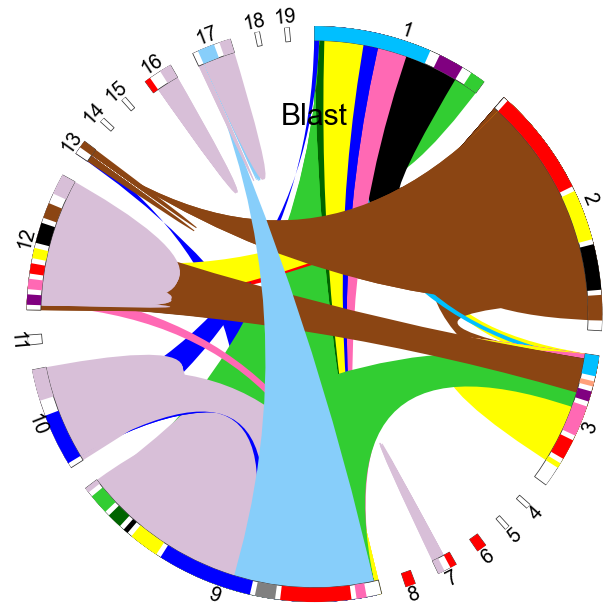

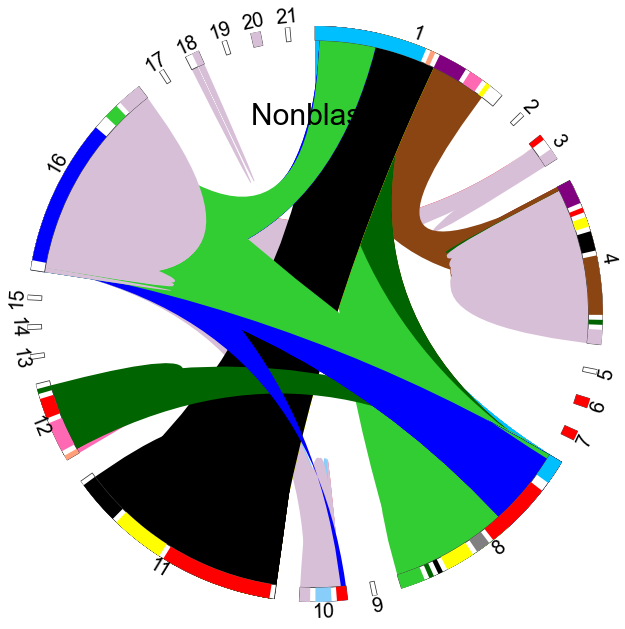

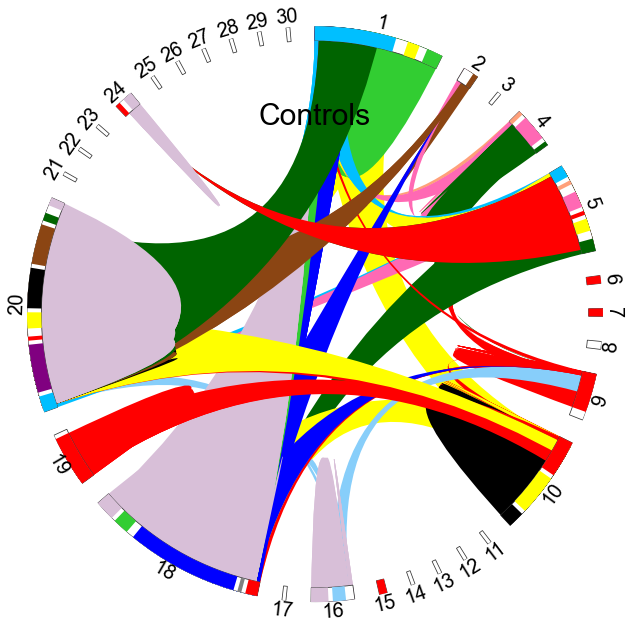

In [28]:
def official_run():
    obj = ReadExcelFile( cfg.Ginput_file )
    obj.process_sheets()
    # obj.analyze_data() # SHOWS ALL!!
    obj.plot_all()

official_run()

Opened File: Partitions_new.xlsx
 Sheets:[('Blast', 'Blast matrix'), ('Nonblast ', 'Nonblast matrix'), ('Controls', 'Control matrix')]
***TEST test_process_sheets() Controls Control matrix

Overwrite: Controls_sorted.csv
Control matrix Nodes with 0.0 values:  [67, 104, 110, 210, 242, 244, 255, 259, 260, 262]
Controls Partitions with 1 Network: [3, 11, 12, 13, 14, 17, 21, 22, 23, 25, 26, 27, 28, 29, 30]
Controls Networks with 1 Node: [5, 6, 9, 2, 5, 10, 4, 2, 11, 2, 3, 5, 9, 5, 5, 5, 14, 6, 7, 5, 5, 5, 5, 5, 5, 7, 5, 6, 8, 14, 5, 6, 12, 14, 14, 14, 5, 14, 14, 14, 14, 14, 14]
DRAW_PARTS_WITH_ONE_NODE=True
PlotChords() total_num_chords=201 Partition=
BRITT PlotChords ZeroDivisionError ('20', 42, 1, 1000) ('3', 0, 1, 1000) saddlebrown
+++ ALL PARTITION INFO FOR SheetControls Partition20
{'start': 195,
 'nets': [1,
          1,
          1,
          1,
          1,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
         

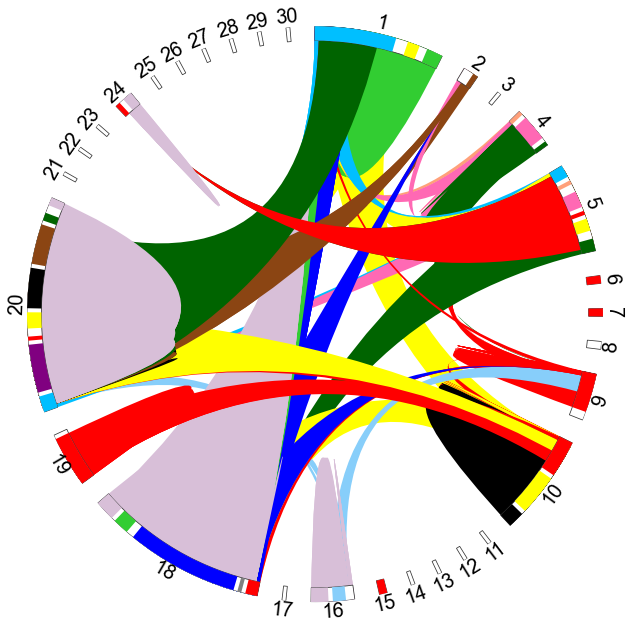

In [29]:
# BRITT - TEST to read in Excel files 5/9/22 !!!
# 
def test_read_excel(sheet,matrix_sheet):
    obj = ReadExcelFile( cfg.Ginput_file )
    obj.test_process_sheets(sheet,matrix_sheet) 
    # obj.analyze_data() # SHOWS ALL!!
    return obj

sheet='Controls'
matrix_sheet='Control matrix'
eobj = test_read_excel(sheet,matrix_sheet)

part_rows = eobj.get_part_rows(sheet)
net_rows = eobj.get_net_rows(sheet)
node_rows = eobj.get_node_rows(sheet)



cir2 = PlotParts(part_rows )
cir2 = PlotNetworks(net_rows,cir2,cfg.unh_colors1)
PlotChords(node_rows,cir2)

p=20
eobj.print_all_part_info(sheet,p)
eobj.analyze_data_part(sheet,p)
# eobj.analyze_data()

In [30]:
p=20
eobj.print_all_part_info(sheet,p)
eobj.analyze_data_part(sheet,p)

+++ ALL PARTITION INFO FOR SheetControls Partition20
{'start': 195,
 'nets': [1,
          1,
          1,
          1,
          1,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          3,
          5,
          5,
          6,
          8,
          8,
          8,
          8,
          8,
          9,
          9,
          9,
          9,
          9,
          9,
          9,
          9,
          9,
          9,
          9,
          10,
          10,
          10,
          10,
          10,
          10,
          10,
          10,
          10,
          10,
          10,
          11,
          11,
          11,
          12,
          14,
          14,
          14],
 'end': 249,
 'len': 55,
 'partid': '20',
 'rel_nets': {1: {'start': 0, 'end': 4, 'len': 5, 'nodes': [2, 3, 4, 9, 17]},
              3: {'start': 5,
                  'end': 17,
                  '

In [31]:
# eobj.analyze_data()
# p=1 # many nodes
# p=2 # many nodes
# p=3 # many nodes
# p=4 # no node rows
# p=5 # no node rows
# p=6 # no node rows
p=7 # 4 node rows
eobj.analyze_data_part(sheet,p)
eobj.print_all_part_info(sheet,p)


Partition: 7
    Networks: #2, [5]
    Networks containing 1 Node: []
    Nodes:    #2, [71, 116]
    Nodes Skip: []
Node Rows: []
+++ ALL PARTITION INFO FOR SheetControls Partition7
{'start': 74,
 'nets': [5, 5],
 'end': 75,
 'len': 2,
 'partid': '7',
 'rel_nets': {5: {'start': 0, 'end': 1, 'len': 2, 'nodes': [71, 116]}},
 'net_row': [(7, 0, 1, 5)],
 'nodes': [71, 116],
 'nodes_start_stop': {71: {'start': 0,
                           'end': 0,
                           'len': 1,
                           'netw': 5,
                           'node_abs_col': 75,
                           'part': 7,
                           'skip': ['src=dest 71,116'],
                           'dest_node': 116},
                      116: {'start': 1,
                            'end': 1,
                            'len': 1,
                            'netw': 5,
                            'node_abs_col': 76,
                            'part': 7,
                            'skip': ['src=des

In [32]:
class ChordCircle:
    def __init__(self,title):
        self.title = title
    
    def plot_it(self,part_dict, nodes_list):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        print("\n\n***** Plotting Image ..... Please wait ~30 seconds.")
        self.part_dict = part_dict

        self.circ = self.draw_partitions(self.part_dict)
        self.draw_netw(self.circ,part_dict)
        self.draw_arcs(self.circ,nodes_list)
        self.circ.figure.suptitle("\n\n"+self.title, fontsize=30)

    def draw_partitions(self,part_dict,SKIP_LENGTH_1=False):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        # partition colors
        color_dict = ColorDict().get_matplot_colors('rainbow',
                        len(part_dict.keys())+1)
        # plot circle
        circ = pycircos.Gcircle() 

        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            length = p['len']
            if length>1 or (length==1 and not SKIP_LENGTH_1):
                arcc = pycircos.Garc(arc_id=str(partid), size=length, 
                                interspace=cfg.INTERSPACE, 
                                raxis_range=(950,1000), 
                                facecolor=color_dict[partid],
                                labelsize=20,
                                labelposition=60, label_visible=True)
            circ.add_garc(arcc) 
        circ.set_garcs(0,360) # this displays the circle          
        circ.figure.suptitle("\n\n"+self.title, 
                fontsize=30)   
        return circ

    def draw_netw( self, circ ,part_dict):
        # draw_networks
        # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
        ''' REQUIRES: 
                    part,
                    number of networks, 
                    network start col within part
                    width of network
                    network id = color
        '''

        # Use CUSTOM COLOR MAP
        # color_dict = ColorDict().get_matplot_colors('viridis',15) # FOR NOW
        color_dict = COLOR_DICT

        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            # print('Part:',p['partid'],'Part Len=',p['len'],"\nNetwork\n")
            length = p['len']
            if length>1: # or (length==1 and not SKIP_LENGTH_1):
            #     # print("col_start,net_width,net")
            # BRITT = THIS IS ALREADY CREATED in pdict['net_rows'] #TODO
                for netw in p['rel_nets'].keys():
                    n = p['rel_nets'][netw]
                    # print("RELNET",p['partid'],n['start'],n['len'],netw)
                    # return
                    circ.barplot( p['partid'], 
                            data = [1], # number to draw (only drawing 1 at a time)
                            positions = [n['start']], 
                            width = [n['len']],
                            raxis_range=[950,1000], 
                            facecolor = [ color_dict[netw] ]
                    )


    def draw_arcs(self, circ, nodes:list):
        # print("draw_arcs ARCS # of nodes",len(nodes))

        # skip nodes in partitions of length 1
        skip_nodes = []
        rows = []
        for p,s,sw,d,dw,n,net in nodes:
            if self.part_dict[p]['len'] >1:
                rows.append((p,s,sw,d,dw,n,net))
            else:
                skip_nodes.append((p,n))

        print(f'\n({self.title})',"Nodes#:",len(nodes),'Skipping:',len(skip_nodes),
                'Plotting:',len(rows))

        for p,s,sw,d,dw,n,net in rows:
            src = (str(p),s,sw,1000)
            dest = (str(p),d,dw,1000)

            # print("ARC",src,dest,net)
            color = COLOR_DICT[net]
            if cfg.BLACK_LINES:
                color = 'black'
            circ.chord_plot(src, dest, facecolor=color)
            if DBG_ARC and p>1:
                print(f"DEBUG: only Part={p} arcs")
                print(src,dest)
                return
    #BRITT
    def test_plot_it(self,part_dict, nodes_list,plot_type,num_arcs):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        print("\n\n***** Plotting Image ..... Please wait ~30 seconds.")
        self.part_dict = part_dict

        self.circ = self.draw_partitions(self.part_dict)
        if plot_type=='just_parts':
            return
        self.draw_netw(self.circ,part_dict)
        if plot_type=='parts_nets':
            return
        self.test_draw_arcs(self.circ,nodes_list,num_arcs)

        self.circ.figure.suptitle("\n\nTESTING"+self.title, fontsize=30)

    def test_draw_arcs(self, circ, nodes:list, draw_num_arcs:int):
        print("TEST draw_arcs ARCS # of nodes",len(nodes)," ONLY:",draw_num_arcs)

        # skip nodes in partitions of length 1
        skip_nodes = []
        rows = []

        draw_ct = 0
        for p,s,sw,d,dw,n,net in nodes:
            if draw_ct == draw_num_arcs:
                print("****BREAK test_draw_arcs() only draw {num_arcs}.")
                break

            if self.part_dict[p]['len'] >1:
                print("ARC: ",p,s,sw,d,dw,n,net)
                rows.append((p,s,sw,d,dw,n,net))
            else:
                skip_nodes.append((p,n))


            draw_ct+=1

        print(f'\nTETS*****({self.title})',"Nodes#:",len(nodes),'Skipping:',len(skip_nodes),
                'Plotting:',len(rows))

        print("Part Dict for THIS NODE: ")
        print(self.part_dict[1]['rel_nets'])

        print("NODES LIST",rows)
        print("DRAW TEST CHORD AT EDGE:")

        for p,s,sw,d,dw,n,net in rows:
            src = (str(p),s,sw,1000)
            dest = (str(p),d,dw,1000)
            print("++ DRAW: src",src,' DEST:',dest)
            print(f'Part {p} src {s} dest {d}')

            # print("ARC",src,dest,net)
            color = COLOR_DICT[net]
            if cfg.BLACK_LINES:
                color = 'black'
            circ.chord_plot(src, dest, facecolor=color)
            if DBG_ARC and p>1:
                print(f"DEBUG: only Part={p} arcs")
                print(src,dest)
                return
  
    def NEWdraw_partitions(self,part_dict):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        # partition colors
        color_dict = ColorDict().get_matplot_colors('rainbow',
                        len(part_dict.keys())+1)
        # plot circle
        circ = pycircos.Gcircle() 
 
        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            length = p['len']
            # HAVE to DRAW ALL PARTS since END cols are determined
           
            arcc = pycircos.Garc(arc_id=str(partid), size=length, 
                                interspace=cfg.INTERSPACE, 
                                raxis_range=(950,1000), 
                                facecolor=color_dict[partid],
                                labelsize=20,
                                labelposition=60, label_visible=True)
            circ.add_garc(arcc) 

        circ.set_garcs(0,360) # this displays the circle          
        circ.figure.suptitle("\n\n"+self.title, 
                fontsize=30)   
        return circ


    def NEWdraw_netw( self, circ ,part_dict, part_to_draw=0):
        # draw_networks
        # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
        ''' REQUIRES: 
                    part,
                    number of networks, 
                    network start col within part
                    width of network
                    network id = color
        '''
        # Use CUSTOM COLOR MAP
        # color_dict = ColorDict().get_matplot_colors('viridis',15) # FOR NOW
        color_dict = COLOR_DICT
        if part_to_draw > 0:
            print("BRITT NEW DRAW NETS only for PART ",part_to_draw)
            p = part_dict[part_to_draw]
            print("\n==== PART INFO: ")
            pprint.pp(p)
            # print(f'\nNetworks for Part: {partid}',p['net_row'])
            # FAILS IF THERE IS ONLY 1 NETWORK!!!! divide by zero/size
            if len(p['net_row'])>1: 
                for row in p['net_row']:
                    # print(row)
                    part, start, width, netw = row
                    circ.barplot( str(part), # partition is string!
                        data = [1], # number to draw (only drawing 1 at a time)
                        positions = [start], 
                        width = [width],
                        raxis_range=[950,1000], 
                        facecolor = [ color_dict[netw] ]
                    )
        else:
            for partid in part_dict.keys():
                # partid MUST be a STRING
                p = part_dict[partid]
                # print(f'\nNetworks for Part: {partid}',p['net_row'])
                # FAILS IF THERE IS ONLY 1 NETWORK!!!! divide by zero/size
                if len(p['net_row'])>1: 
                    for row in p['net_row']:
                        # print(row)
                        part, start, width, netw = row
                        circ.barplot( str(part), # partition is string!
                            data = [1], # number to draw (only drawing 1 at a time)
                            positions = [start], 
                            width = [width],
                            raxis_range=[950,1000], 
                            facecolor = [ color_dict[netw] ]
                        )
 

    def NEWdraw_arcs(self, circ, part_dict, part):
        # print("draw_arcs ARCS # of nodes",len(nodes))
        print("++= TEST DRAW ARCS FOR JUST PART=",part)
        pprint.pp( part_dict[part] )

        print("NET ROW FOR 6", COLOR_DICT[5])
        # # skip nodes in partitions of length 1
        # skip_nodes = []
        # rows = []
        # for p,s,sw,d,dw,n,net in nodes:
        #     if self.part_dict[p]['len'] >1:
        #         rows.append((p,s,sw,d,dw,n,net))
        #     else:
        #         skip_nodes.append((p,n))

        # print(f'\n({self.title})',"Nodes#:",len(nodes),'Skipping:',len(skip_nodes),
        #         'Plotting:',len(rows))

        # for p,s,sw,d,dw,n,net in rows:
        #     src = (str(p),s,sw,1000)
        #     dest = (str(p),d,dw,1000)

        #     # print("ARC",src,dest,net)
        #     color = COLOR_DICT[net]
        #     if cfg.BLACK_LINES:
        #         color = 'black'
        #     circ.chord_plot(src, dest, facecolor=color)
        #     if DBG_ARC and p>1:
        #         print(f"DEBUG: only Part={p} arcs")
        #         print(src,dest)
        #         return


In [33]:

def run():
    obj = ReadExcelFile( cfg.Ginput_file )
    obj.process_sheets() 
    obj.draw_all()
# run() #UNCOMMENT TO RUN ALL PLOTS

In [34]:
# # TESTING CODE USINF NEW DICTS!!!! BRITT
#
# # 
# DBG = False
# DBG_ARC = True

# sheet = 'Blast'
# msheet = 'Blast matrix'

# excel_obj = ReadExcelFile( cfg.Ginput_file )
# # builds Part map with ALL INFORMATIOM
# circ_data = DataList( excel_obj.dfs, sheet, msheet)




In [35]:
# # draw part BRIIT M - WITH NEW DICTS!!!
# cir = ChordCircle(sheet)
# circ_fig = cir.NEWdraw_partitions( circ_data.part_map)
# cir.NEWdraw_netw( circ_fig, circ_data.part_map,1 )
# part=6
# cir.NEWdraw_arcs( circ_fig, circ_data.part_map, part )  


In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_color_bar(colors,label,tick_labels):
    cmap= mpl.colors.ListedColormap(colors)

    # one more and make ''
    bounds = tick_labels+[ tick_labels[-1]+1]

    # used to draw ticks
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # defines the width of the entire plot - 10 is wider
    fig, ax = plt.subplots(figsize=(20, 1))
    ax.tick_params(labelsize=40)
    
    #  defines the height of the entire plot
    # fig.subplots_adjust(bottom=0.5) # this makes it 1/2 the height
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap,norm=norm),
        cax=ax,
        orientation='horizontal',
        label=label,
    )
    # fig.suptitle('test title', fontsize=20) # is ontop of color bar
    plt.show()

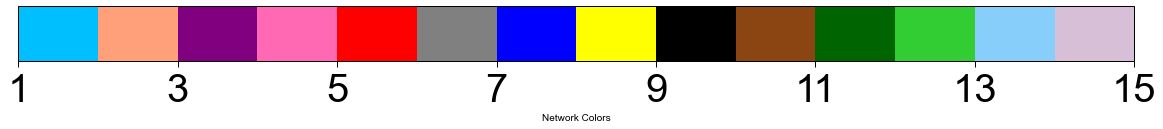

In [37]:
# https://matplotlib.org/3.5.0/gallery/color/named_colors.html

color_names = list(cfg.unh_colors1.values())
color_nums = list( cfg.unh_colors1.keys())
show_color_bar(color_names,'Network Colors',color_nums)